# Intro To Geopandas
**Pandas for geospatial data**

Personally whenever I am faced with a problem that involves analysing geospatial data, [GeoPandas](http://geopandas.org/) is the first tool/package I reach for. Extending on the [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) data structure, GeoPandas brings functionality for working with points, polygons and more out of the box. This post is to go through some basic geometry functions which I find myself countless times in GIS work.

## First Steps

A [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), is essentially a tabular representation of a dataset; a GeoPandas dataframe is an extension on this tabular format that includes a 'geometry' column and a crs. The 'geometry' column is exactly as it sounds, it contains the geometry of the point, line or polygon that is assosciated with the rest of the columns (this is defined by the shapely module). The crs (Coordinate Reference System) attribute to a GeoPandas dataframe contains the projection of the data into the real world (eg, WGS84)

Let's begin by creating some example geometries with Shapely to include in our GeoDataFrame.

In [1]:
import geopandas
import pandas
from shapely.geometry import Polygon, Point

In [2]:
p1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])

gdf = geopandas.GeoDataFrame(columns=['geometry'],data=[p1,p2,p3])

gdf['Data'] = {0: 0, 1: 1, 2: 2}

display(gdf)

,geometry,Data
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0
1,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",1
2,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....",2


As we can see, our new polygons and their assosciated data is given in a tabular format and can be worked with like a Pandas DataFrame. For me personally, I find GIS work to be a very visual process and struggle to imagine the shapes without them in front of me, so let's plot them. Luckily for us this is a very simple process as there is already a plot function within GeoPandas.

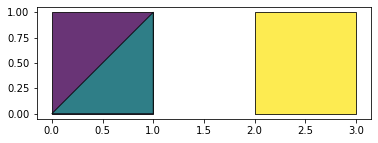

In [3]:
plt = gdf.plot(cmap='viridis',edgecolor='black',alpha=0.8)

If you didn't notice from the polygon definition, we've created 2 squares (purple & yellow) and one triangle. Now what if we wanted to know the area of all of the shapes in our GeoDataFrame. Since we've initialised our data in a GeoDataFrame this can be done quite easily.

In [4]:
gdf['Shape Area'] = gdf.geometry.apply(lambda x: x.area)
display(gdf)

,geometry,Data,Shape Area
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0,1.0
1,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",1,0.5
2,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....",2,1.0


To break down what's happening above, we are 'creating' a new column in our GeoDataFrame named 'Shape Area'. Following this, we are selecting the 'geometry' column (this can also be achieved with gdf`['geometry']`) and using the apply function. The apply function works by iterating over each row invidually (in this case it's simply each value in the geometry column). After this we are creating an 'anonymous' function, meaning, it's a function that doesn't require a definition. For each value in our geometry column, since they are Shapely objects, we can access the area function within them. Finally you can see the areas are calculated and added as a new column.

## Overlapping Area

Now let's use what we have just learned to find the area that is overlapping of two shapes. To create the shapes this time though, we are going to start with a point and use the buffer function to make this a polygon. Following this, we will give the DataFrame some data, initialise the GeoDataFrames, calculate the area and plot them on a single graph.

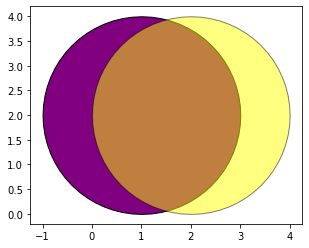

In [5]:
p1 = Point((1,2)).buffer(2)
p2 = Point((2,2)).buffer(2)

df_1 = pandas.DataFrame({'a': [11]})
df_2 = pandas.DataFrame({'b' : [22]})

gdf_1 = geopandas.GeoDataFrame(df_1, geometry = [p1])
gdf_2 = geopandas.GeoDataFrame(df_2, geometry = [p2])

gdf_1['area'] = gdf_1.geometry.apply(lambda x: x.area)
gdf_2['area'] = gdf_2.geometry.apply(lambda x: x.area)

ax = gdf_1.plot(color='purple',edgecolor='k')
gdf_2.plot(ax=ax,color='yellow',edgecolor='k',alpha=0.5)

Now it's time to make use of the overlay function within GeoPandas. There are many implemented methods within the overlay function which are outlined here: [Set Operations with Overlay](http://geopandas.org/set_operations.html). We will be using the intersection method, which will only return the area of each geometry which overlaps.

Notice below when we display the GeoPandas GeoDataFrame and plot the result that we have only returned the overlapping area, with data brought from both underlying geometries (a and b) column.

,a,area_1,b,area_2,geometry
0,11,12.546194,22,12.546194,"POLYGON ((3.00000 2.00000, 2.99037 1.80397, 2...."


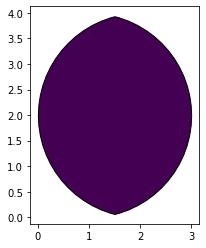

In [6]:
overlay = geopandas.overlay(gdf_1,gdf_2,how='intersection')

overlay.plot(cmap='viridis',edgecolor='k')
display(overlay)
# total_gdf = geopandas.GeoDataFrame(pandas.concat([gdf_1,gdf_2,overlay],ignore_index=True,sort=False))
# display(total_gdf)

Now we can reuse our methodology from before to recalculate the area that is overlapping.

In [7]:
overlay['Overlapping Area'] = overlay.geometry.apply(lambda x: x.area)
display(overlay)

,a,area_1,b,area_2,geometry,Overlapping Area
0,11,12.546194,22,12.546194,"POLYGON ((3.00000 2.00000, 2.99037 1.80397, 2....",8.591554


## Distance to Nearest Point from Polygon

Another common type of analysis that we would like to make, is how far a particular polygon may be from a point.

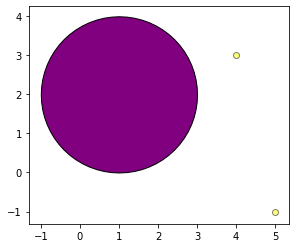

In [8]:
p1 = Point((1,2)).buffer(2)
p2 = Point((4,3))
p3 = Point((5,-1))

df_1 = pandas.DataFrame({'a': [11]})
df_2 = pandas.DataFrame({'b' : [22,33]})

gdf_1 = geopandas.GeoDataFrame(df_1, geometry = [p1])
gdf_2 = geopandas.GeoDataFrame(df_2, geometry = [p2,p3])

ax = gdf_1.plot(color='purple',edgecolor='k')
gdf_2.plot(ax=ax,color='yellow',edgecolor='k',alpha=0.5)

In [9]:
gdf_2.geometry.apply(lambda x: gdf_1.distance(x))

,0
0,1.163931
1,3.002337


This will calculate the distance at each point to our polygon, from this we can select the minimum value.

In [10]:
gdf_2.geometry.apply(lambda x: gdf_1.distance(x)).min()

0    1.163931
dtype: float64

Notice that this returns a GeoSeries, so we have to select the first element (Zeroth in Python).

In [11]:
gdf_2.geometry.apply(lambda x: gdf_1.distance(x))[0].min()

1.163931136530937

## Count of Points in Polygon

The final application in this point will be to count the amount of points within a polygon.

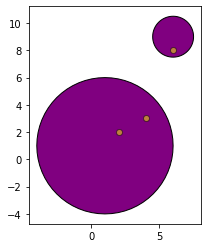

In [12]:
p1 = Point((1,1)).buffer(5)
p2 = Point((6,9)).buffer(1.5)
p3 = Point((2,2))
p4 = Point((4,3))
p5 = Point((6,8))

df_1 = pandas.DataFrame({'a': [11,22]})
df_2 = pandas.DataFrame({'b' : [33,44,55]})

gdf_1 = geopandas.GeoDataFrame(df_1, geometry = [p1,p2])
gdf_2 = geopandas.GeoDataFrame(df_2, geometry = [p3,p4,p5])

ax = gdf_1.plot(color='purple',edgecolor='k')
gdf_2.plot(ax=ax,color='yellow',edgecolor='k',alpha=0.5)


We are looking to have our answer be 2 for the larger polygon and 1 for the smaller circle. To make sure we are getting the right answers, let's provide an identifying column for each polygon. This is completed by using the apply function again, row wise (axis=1) and by concatenating the word 'Polygon' with the row number (this is called name in Pandas).

In [13]:
gdf_1['id'] = gdf_1.apply(lambda x: 'Polygon ' + str(x.name),axis=1)

display(gdf_1)

,a,geometry,id
0,11,"POLYGON ((6.00000 1.00000, 5.97592 0.50991, 5....",Polygon 0
1,22,"POLYGON ((7.50000 9.00000, 7.49278 8.85297, 7....",Polygon 1


Now we are going to use a spatial join function, like the overlay previously, this also has many methods within it. They are all detailed here: [Merging Data in GeoPandas](http://geopandas.org/mergingdata.html). For this application we will use the within operator.

In [14]:
spatial_join = geopandas.sjoin(gdf_2,gdf_1,op='within')
display(spatial_join)

,b,geometry,index_right,a,id
0,33,POINT (2.00000 2.00000),0,11,Polygon 0
1,44,POINT (4.00000 3.00000),0,11,Polygon 0
2,55,POINT (6.00000 8.00000),1,22,Polygon 1


As we can see above, the output GeoDataFrame from this is all of our points and the id containing the Polygon they live in.

Next we will group them by id, count how many of them there is (with .size()) and create a new DataFrame with the results of our analysis.

In [15]:
grouped = spatial_join.groupby('id').size()

display(grouped)

df = grouped.to_frame().reset_index()

df.columns = ['id','Count']

display(df)

id
Polygon 0    2
Polygon 1    1
dtype: int64

,id,Count
0,Polygon 0,2
1,Polygon 1,1


To bring this back into our original GeoDataFrame, this is acheieved with the merge function.

In [16]:
gdf_1.merge(df, on='id', how='outer')

,a,geometry,id,Count
0,11,"POLYGON ((6.00000 1.00000, 5.97592 0.50991, 5....",Polygon 0,2
1,22,"POLYGON ((7.50000 9.00000, 7.49278 8.85297, 7....",Polygon 1,1
